# 2-D Advection Diffusion Reduced Order Modelling

Candidate: Billton Joseph Vitus

Tutors: Joseph MORLIER, Oriol CHANDRE-VILA 

----------------------------------------------------------------------

Package imports and initialisations

In [1]:
from __future__ import print_function
import numpy as np
import scipy as sp
import math
import time
import matplotlib.pyplot as plt

import matplotlib.tri as mtri
import matplotlib.pyplot as plt

from ezyrb import POD, RBF, Database
from ezyrb import ReducedOrderModel as ROM

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#---------------------------Initialisation-----------------------------
Nx = 61 #number of nodes in X axis
Ny = 61 #number of nodes in Y axis
Lx = 1.  #Length in X 
Ly = 1.  #Length in Y
dx = Lx/(Nx-1); #Step size in X
dy = Ly/(Ny-1); #Step size in Y
x = np.linspace(0,Lx,Nx)  #Row vector for x
y = np.linspace(0,Ly,Ny)  #Row vector for y
Ti = 300 
Tleft = 950

npoints = 10
ncomp = npoints**3
wcomp = np.zeros(((Nx-2)*(Ny-2), ncomp))

Next we have all the functions to solve the PDE for the reference solution.

In [2]:
#-----------------------Functions------------------------------------
# Computing A1
def computeA1():
    D2x = np.zeros((Nx-2,Nx-2))
    for i in range (0,Nx-2):
        for j in range (0,Nx-2):
            if i == j:
                D2x[i,j] = -2
            elif j == i+1:
                D2x[i,j] = 1
            elif j == i-1:
                D2x[i,j] = 1
    D2x[Nx-3,Nx-3] = -1
    D2x = (1/dx**2)*D2x
    
    D2y = np.zeros((Ny-2,Ny-2))
    for i in range (0,Ny-2):
        for j in range (0,Ny-2):
            if i == j:
                D2y[i,j] = -2
            elif j == i+1:
                D2y[i,j] = 1
            elif j == i-1:
                D2y[i,j] = 1
    D2y[Ny-3,Ny-3] = -1
    D2y[0,0] = -1    
    #pdb.set_trace()    
    D2y = (1/dy**2)*D2y
    
    A1 = sp.sparse.kron(D2x, np.eye(Ny-2)) + sp.sparse.kron(np.eye(Nx-2), D2y)
    
    return A1

#computing A2
def computeA2():    
    D1x = np.zeros((Nx-2,Nx-2))
    for i in range (0,Nx-2):
        for j in range (0,Nx-2):
            if i == j:
                D1x[i,j] = 1
            elif j == i+1:
                D1x[i,j] = 0
            elif j == i-1:
                D1x[i,j] = -1   
        
    D1x = (1/dx)*D1x
    
    A2 = np.kron(D1x, np.eye(Ny-2))
    
    return A2

#computing B1
def computeB1(u, kappa, ybar):
    TleftBC = np.zeros((Ny-2,1))
    b1 = np.zeros((Ny-2,1))
    for i in range(1,Ny-1):  #adjust range from matlab
        if y[i]<Ly/3:
            TleftBC[i-1,0] = Ti
            b1[i-1,0] = -((u/dx) + kappa/dx**2)*TleftBC[i-1,0]
        elif y[i] > 2*Ly/3:
            TleftBC[i-1,0] = Ti
            b1[i-1,0] = -((u/dx) + kappa/dx**2)*TleftBC[i-1,0]
        else:
            TleftBC[i-1,0] = 300 + 325*(np.sin(3*math.pi*np.abs(y[i]-ybar))+1)
            b1[i-1,0] = -(u/dx + kappa/dx**2)*TleftBC[i-1,0]
    return b1, TleftBC


#Advection Diffusion Operator
def buildadvdefop(u, kappa, ybar):
    if u<0:
        print('u must be positive')
    [b1, TleftBC] = computeB1(u, kappa, ybar)
    b = np.vstack((b1, np.zeros(((Nx-3)*(Ny-2),1))))
    
    A1 = computeA1()
    A2 = computeA2()
    A = (kappa*A1) - (u*A2)
    return A, b, TleftBC

In the following line of code, we set the parameters for [ν, κ, y̅], which are the advection speed in the X-direction, diffusion coefficient and the parametrised boundary condition. This will be used to run the reference simulation and the first iteration of the ROM.

In [3]:
#--------------------PARAM----------------------------------
pcomp = [0.136667, 0.0248667, 0.470667]
#-----------------------------------------------------------

We now calculate the reference solution for a comparison with the ROM output, and for error estimation.

In [4]:
#reference solution
tic2 = time.time()
[A,b,TleftBC] = buildadvdefop(pcomp[0], pcomp[1], pcomp[2])
wcomp = np.linalg.solve(A,b).T.squeeze()
tfull = time.time() - tic2
print(f'Time for full case is {tfull:.3f} sec')

#Left wall BC
TleftBC = np.zeros((Ny-2,1))
for i in range(1,Ny-1):  #adjust range from matlab
        if y[i]<Ly/3:
            TleftBC[i-1,0] = Ti
        elif y[i] > 2*Ly/3:
            TleftBC[i-1,0] = Ti
        else:
            TleftBC[i-1,0] = 300 + 325*(np.sin(3*math.pi*np.abs(y[i]-pcomp[2]))+1)

Time for full case is 1.968 sec


We use the EZyRB library as the ROM generator module in this study. The only inputs for this library is the snapshot matrix and the parameter matrix. 

We first train the ROM in the offline phase with the code below. We use pre-generated snapshot matrix and parameter matrix using the snapshotgen.py code.

In [5]:
#POD offline Phase
t_pod_offline = time.time()

snapshots = np.load('//Snapshots//Snapshot75.npy')
print(f'Total number of columns in snapshot matrix = {len(snapshots[0])}')
limit = int(0.8*len(snapshots[0]))
snapshots = snapshots[:,0:limit]
snapshots = np.transpose(snapshots)    

param = np.load('//Param//Param75.npy')
param = param[:,0:limit]
param = np.transpose(param)

db = Database(param, snapshots)
pod = POD('svd')
rbf = RBF()
rom = ROM(db, pod, rbf)
rom.fit();
T_POD_offline = time.time() - t_pod_offline
print(f"Training time is {T_POD_offline:.3f} sec")

Total number of columns in snapshot matrix = 75
Training time is 0.676 sec


We deal with the online phase of the ROM code. This is the predictor module, which uses the Radial Basis Function to predict the solutions for the requested design point.

In [6]:
#POD Online Phase
t_pod_online = time.time()
pred_sol = rom.predict(pcomp)
T_POD_online = time.time()-t_pod_online
print(f"Online time is {T_POD_online:.3f} sec")


Online time is 0.010 sec


We use the root mean squared error (RMSE) method for calculating the error. Since the RMSE has the same units as the quantities being compared, the unit is in Kelvin (K). The Relative Error can also be estimated, relative to the reference solution and is given in percentage.

In [7]:
#RMSE
MSE = np.square(np.subtract(wcomp,pred_sol)).mean()
RMSE = math.sqrt(MSE)
print(f"RMS error is {RMSE:.4f}")
speedup = tfull/T_POD_online
print("Speedup in time is %.3f"%speedup)

#Relative Error
# error = np.array((3481,1))
# error = np.divide((pred_sol-wcomp),wcomp)*100
# max_error = max(abs(error))
# avg_error = np.average(abs(error))
# print(f"Max error is {max_error:.4f} %")
# print(f"Average error is {avg_error:.4f} %")

RMS error is 0.0000
Speedup in time is 197.282


The reference solution and the ROM solution is plotted for comparison purposes.

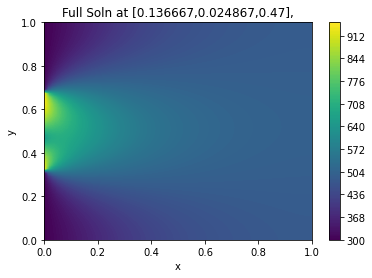

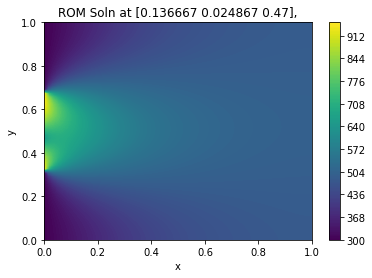

In [8]:
x1 = np.linspace(0,1,60)
y1 = np.linspace(0,1,59)
X,Y = np.meshgrid(x1,y1)

#Full Soln
wcomp = np.transpose(np.reshape(wcomp,(59,59)))
wcomp = np.hstack((TleftBC,wcomp))

plt.contourf(X,Y,wcomp, levels = 200)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Full Soln at [%.6f,%.6f,%.2f],"%(pcomp[0], pcomp[1], pcomp[2]))
plt.colorbar()
plt.show()

#POD plot
pred_sol = np.transpose(np.reshape(pred_sol,(59,59)))
pred_sol = np.hstack((TleftBC,pred_sol))

plt.contourf(X,Y,pred_sol, levels = 200)
plt.xlabel("x")
plt.ylabel("y")
plt.title("ROM Soln at [%.6f %.6f %.2f],"%(pcomp[0], pcomp[1], pcomp[2]))
plt.colorbar()
plt.show()   

Next, we create a widget that allows us to play with the parameter values and shows a real time update of the contour plots for the ROM solution. 

In [9]:
def f(v,k,ybar):
    par = [v,k,ybar]
    pred_sol = rom.predict(par)
    
    TleftBC = np.zeros((Ny-2,1))
    for i in range(1,Ny-1): 
            if y[i]<Ly/3:
                TleftBC[i-1,0] = Ti
            elif y[i] > 2*Ly/3:
                TleftBC[i-1,0] = Ti
            else:
                TleftBC[i-1,0] = 300 + 325*(np.sin(3*math.pi*np.abs(y[i]-par[2]))+1)
    
    x1 = np.linspace(0,1,60)
    y1 = np.linspace(0,1,59)
    X,Y = np.meshgrid(x1,y1)
    pred_sol = np.transpose(np.reshape(pred_sol,(59,59)))
    pred_sol = np.hstack((TleftBC,pred_sol))

    plt.contourf(X,Y,pred_sol, levels = 200)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("ROM Soln at [%.6f %.6f %.2f],"%(par[0], par[1], par[2]))
    plt.colorbar()
    plt.show()
    
interactive_plot = interactive(f, v=(0, 0.5, 0.01), k=(0.0005, 0.025, 0.001), ybar=(0.4, 0.6, 0.02))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.25, description='v', max=0.5, step=0.01), FloatSlider(value=0.0125, …